In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import model_selection
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError

# Test Dickey-fuller
from statsmodels.tsa.stattools import adfuller
from numpy import log

# Random Forest
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBRegressor

# RNN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout



2023-01-24 13:23:46.596855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 13:23:49.505391: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-24 13:23:52.244974: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/javi/anaconda3/envs/masters/lib/
2023-01-24 13:23:52.245588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plu

In [2]:
filename = 'data-export.csv'
data = pd.read_csv(filename, sep = ',', header = 0)

In [3]:
data['Abandon rate'] = 100 * data['ABANDONED_CALLS'] / (data['ABANDONED_CALLS'] + data['HANDLED_CALLS'])

In [4]:
data['Campaign Number'] = data['Campaign Number'].astype(str)

In [5]:
data = data.drop('TOTAL_CALLS', axis='columns')

In [6]:
data.head(10)

Campaign Number  Start Date  ABANDONED_CALLS  HANDLED_CALLS  COUNT_OF_REPS  \
0          237322  2021-01-01                0              1              1   
1          237322  2021-01-02                0              1              1   
2          237322  2021-01-04               30           1034             14   
3          237322  2021-01-05               13            855             14   
4          237322  2021-01-06               12           1078             15   
5          237322  2021-01-07               22           1103             14   
6          237322  2021-01-08               13           1083             14   
7          237322  2021-01-09                0              4              1   
8          237322  2021-01-11               43           1290             14   
9          237322  2021-01-12               17           1192             14   

   Abandon rate  
0      0.000000  
1      0.000000  
2      2.819549  
3      1.497696  
4      1.100917  
5      1.955556  
6      1.186131  
7      0.000000  
8      3.225806  
9      1.406121

In [7]:
data.describe().transpose()

count        mean         std  min   25%         50%  \
ABANDONED_CALLS  14089.0   12.249911   27.153288  0.0   0.0    2.000000   
HANDLED_CALLS    14089.0  545.539499  594.370783  0.0  41.0  357.000000   
COUNT_OF_REPS    14089.0   17.608276   18.281238  1.0   5.0   13.000000   
Abandon rate     14052.0    2.176874    7.884720  0.0   0.0    0.657895   

                        75%     max  
ABANDONED_CALLS   14.000000   620.0  
HANDLED_CALLS    843.000000  3265.0  
COUNT_OF_REPS     23.000000   133.0  
Abandon rate       1.860465   100.0

# Manipulacion de datos

In [8]:
g = data.groupby(['Campaign Number']).size()

In [9]:
g

Campaign Number
237322    612
238467    654
238566     22
240743    637
240875    554
240944    554
241016    508
241058    626
241067    400
241122     42
249337    691
249370    546
249402    635
249435    531
249533    601
249548    609
249616    629
249755    678
249760    619
249813    564
249860      7
249941    508
249942    503
249946    359
249963    239
249969    233
249971     50
250080    118
250097     91
250102     84
250105    181
250107    122
250108     78
250111     94
250113     22
250126      3
250127     27
250129     77
250151     44
250155     59
250157     32
312970    108
315115     23
315116     27
315194    156
315208    132
dtype: int64

In [90]:
chosen_site = '237322'

In [91]:
# Filtering by the chosen site
df = data[(data['Campaign Number'] == chosen_site)]
# Renaming the start date column for easy handling
df = df.rename(columns={'Start Date' : 'date'})
# Adding the datetime format so the system recognizes it
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')
# Adding stationary variables and setting it as an index
df['Month'] = pd.DatetimeIndex(df['date']).month
df['Day of week'] = pd.DatetimeIndex(df['date']).dayofweek
df = df.set_index('date')
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
df = df.asfreq('D')
# Sorting by the index
df = df.sort_index()

## Checking to see if there are null values

In [98]:
df = df.drop('Campaign Number', axis='columns')

In [99]:
print(f'Null values: {df.isnull().sum()}')

Null values: ABANDONED_CALLS    106
HANDLED_CALLS      106
COUNT_OF_REPS      106
Abandon rate       107
Month              106
Day of week        106
dtype: int64


In [101]:
df[df['HANDLED_CALLS'].isna()]

ABANDONED_CALLS  HANDLED_CALLS  COUNT_OF_REPS  Abandon rate  \
date                                                                      
2021-01-09              NaN            NaN            NaN           NaN   
2021-01-10              NaN            NaN            NaN           NaN   
2021-01-17              NaN            NaN            NaN           NaN   
2021-01-24              NaN            NaN            NaN           NaN   
2021-01-30              NaN            NaN            NaN           NaN   
...                     ...            ...            ...           ...   
2022-02-26              NaN            NaN            NaN           NaN   
2022-02-27              NaN            NaN            NaN           NaN   
2022-03-05              NaN            NaN            NaN           NaN   
2022-03-06              NaN            NaN            NaN           NaN   
2022-03-13              NaN            NaN            NaN           NaN   

            Month  Day of week  
date                            
2021-01-09    NaN          NaN  
2021-01-10    NaN          NaN  
2021-01-17    NaN          NaN  
2021-01-24    NaN          NaN  
2021-01-30    NaN          NaN  
...           ...          ...  
2022-02-26    NaN          NaN  
2022-02-27    NaN          NaN  
2022-03-05    NaN          NaN  
2022-03-06    NaN          NaN  
2022-03-13    NaN          NaN  

[106 rows x 6 columns]

In [102]:
# We replace them with 0
df = df.fillna(0)

In [103]:
df[df['HANDLED_CALLS'].isna()]

Empty DataFrame
Columns: [ABANDONED_CALLS, HANDLED_CALLS, COUNT_OF_REPS, Abandon rate, Month, Day of week]
Index: []

In [105]:
# Verifying there are no null values
print(f'Null values: {df.isnull().sum()}')

Null values: ABANDONED_CALLS    0
HANDLED_CALLS      0
COUNT_OF_REPS      0
Abandon rate       0
Month              0
Day of week        0
dtype: int64


In [106]:
# Verifying the index is continuous and 1:1
(df.index == pd.date_range(start=df.index.min(),
                             end=df.index.max(),
                             freq=df.index.freq)).all()

True

In [107]:
# We graph several sites, using the above techniques for data cleaning and show them as they are below
# Site 249760

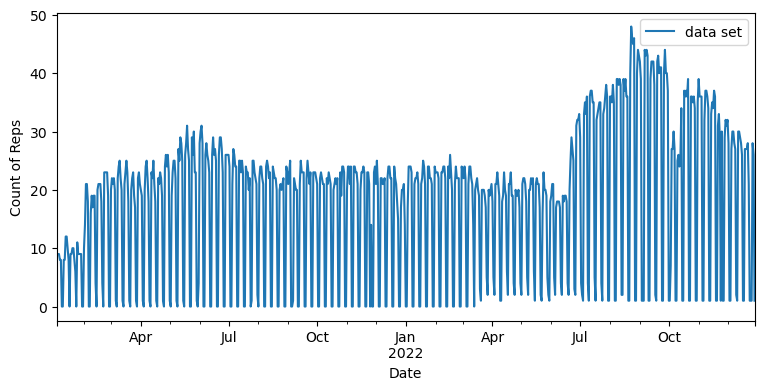

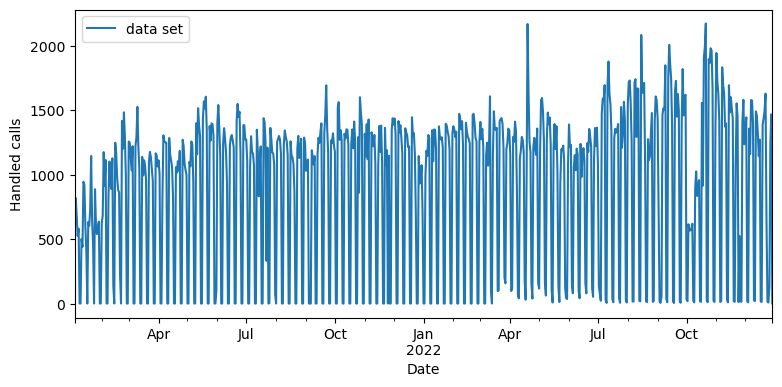

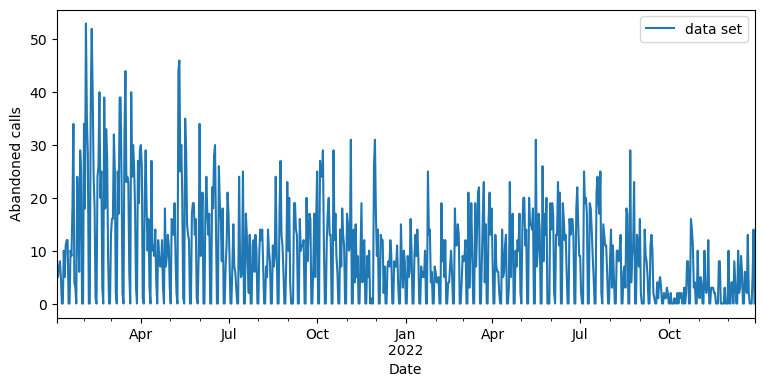

In [108]:
fig, ax = plt.subplots(figsize = (9,4))
df['COUNT_OF_REPS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['HANDLED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['ABANDONED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

In [88]:
# Site 249755

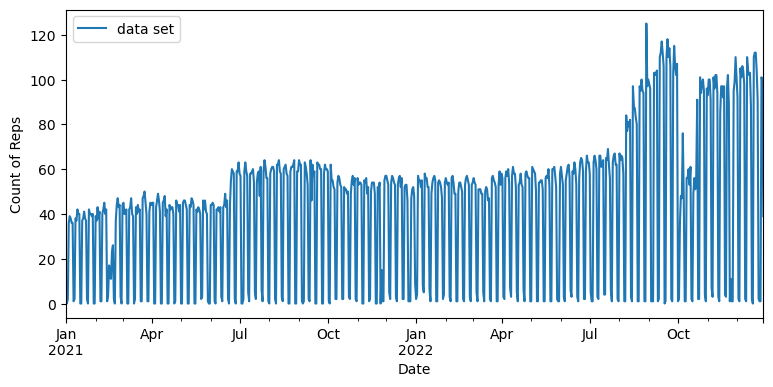

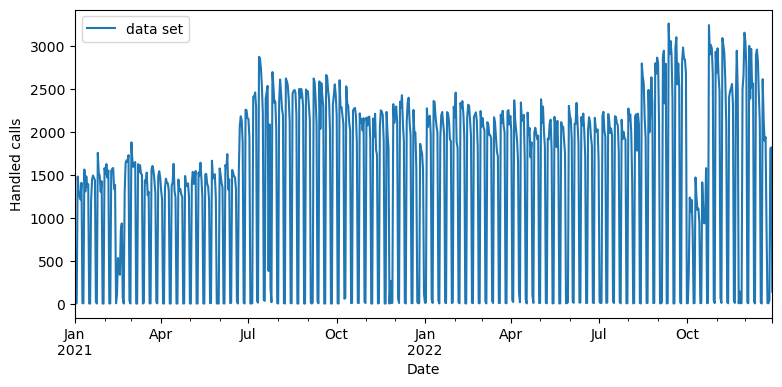

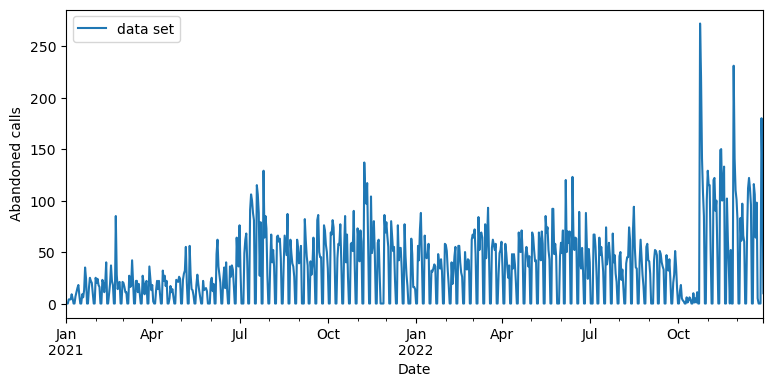

In [89]:
fig, ax = plt.subplots(figsize = (9,4))
df['COUNT_OF_REPS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['HANDLED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['ABANDONED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

In [69]:
# Site 249942

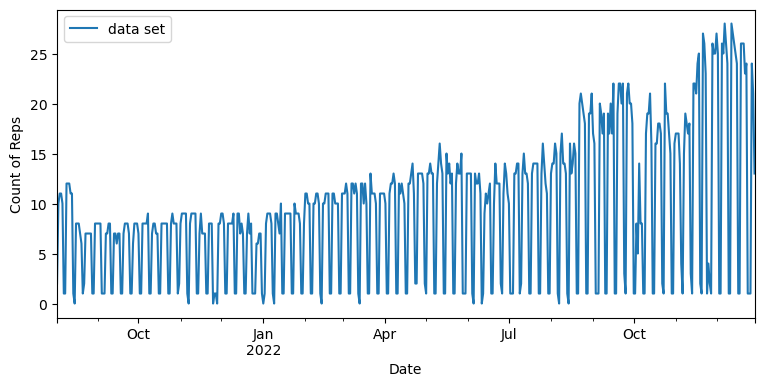

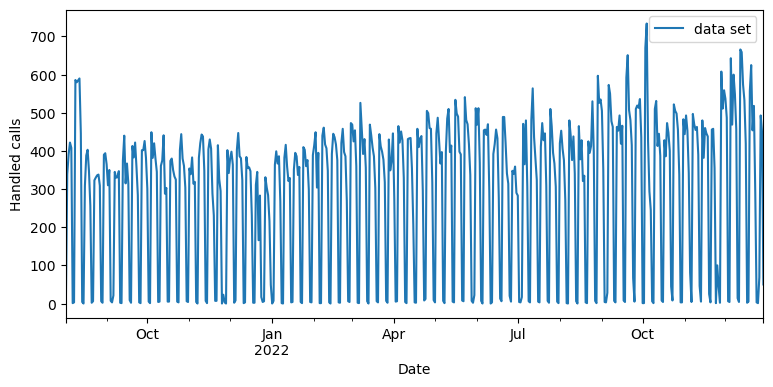

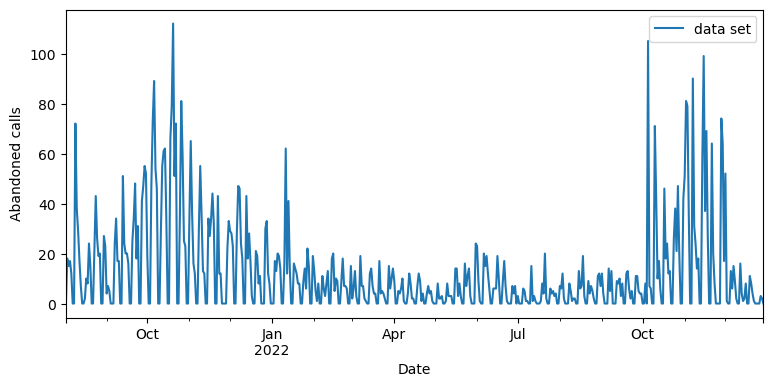

In [70]:
fig, ax = plt.subplots(figsize = (9,4))
df['COUNT_OF_REPS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['HANDLED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['ABANDONED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

In [49]:
# Site 249337

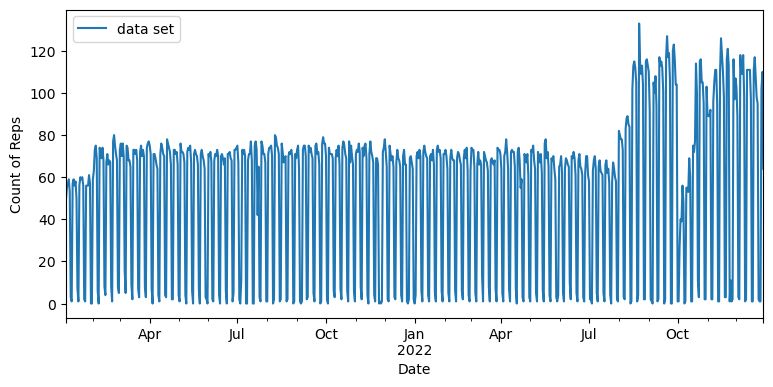

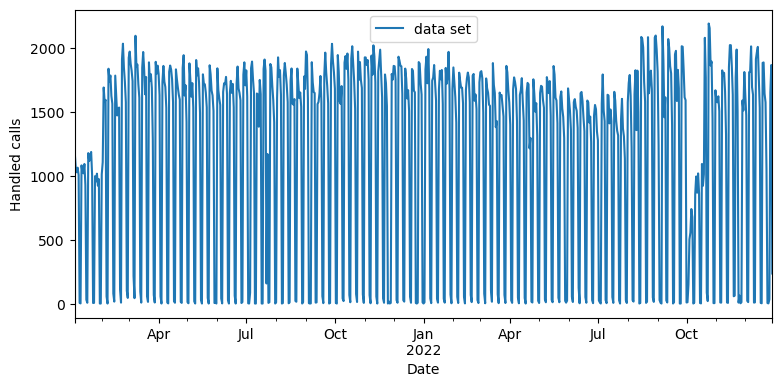

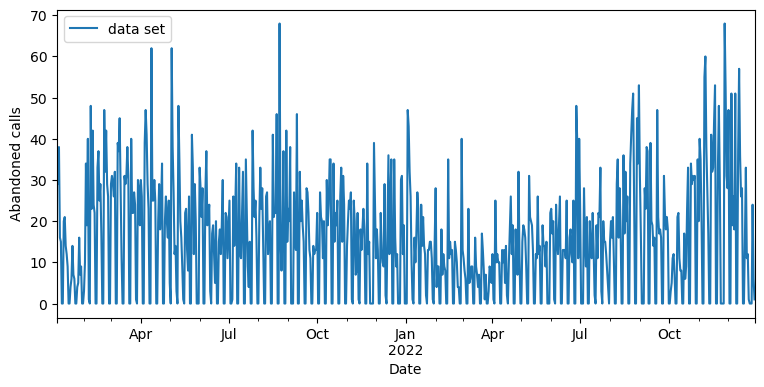

In [51]:
fig, ax = plt.subplots(figsize = (9,4))
df['COUNT_OF_REPS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['HANDLED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()
fig, ax = plt.subplots(figsize = (9,4))
df['ABANDONED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

In [50]:
# Site 237322

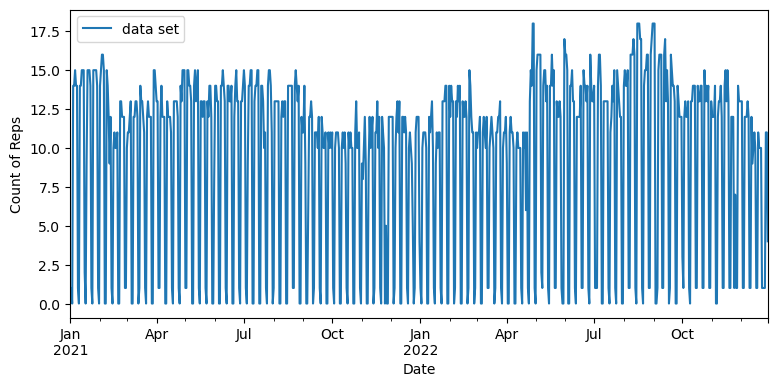

In [27]:
fig, ax = plt.subplots(figsize = (9,4))
df['COUNT_OF_REPS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()

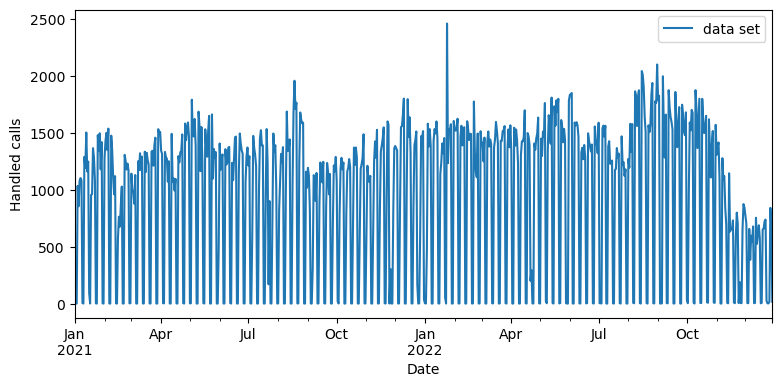

In [28]:
fig, ax = plt.subplots(figsize = (9,4))
df['HANDLED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()

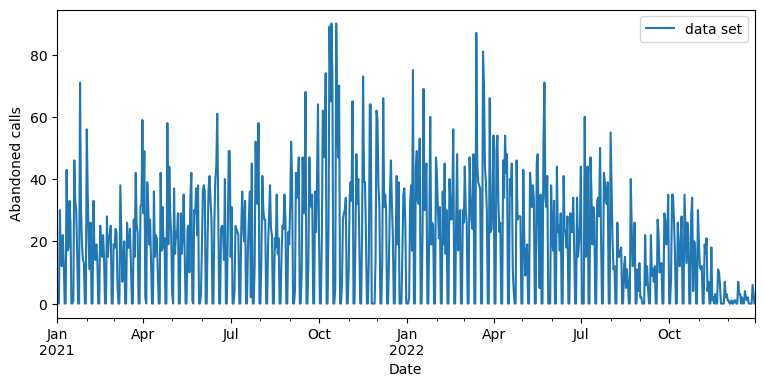

In [31]:
fig, ax = plt.subplots(figsize = (9,4))
df['ABANDONED_CALLS'].plot(ax=ax, label = 'data set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

## Data normalization

In [27]:
# We normalize all but the target column
df_inputs = df.drop('COUNT_OF_REPS',axis='columns')

In [28]:
df_inputs

ABANDONED_CALLS  HANDLED_CALLS  Abandon rate  Month  Day of week
date                                                                        
2021-01-01              0.0            1.0      0.000000    1.0          4.0
2021-01-02              0.0            1.0      0.000000    1.0          5.0
2021-01-03              0.0            0.0      0.000000    0.0          0.0
2021-01-04             30.0         1034.0      2.819549    1.0          0.0
2021-01-05             13.0          855.0      1.497696    1.0          1.0
...                     ...            ...           ...    ...          ...
2022-12-25              0.0            1.0      0.000000   12.0          6.0
2022-12-26              0.0           14.0      0.000000   12.0          0.0
2022-12-27              6.0          841.0      0.708383   12.0          1.0
2022-12-28              3.0          669.0      0.446429   12.0          2.0
2022-12-29              0.0           16.0      0.000000   12.0          3.0

[728 rows x 5 columns]

In [29]:
min_max_scaler = preprocessing.MinMaxScaler()
inputs_scaled=min_max_scaler.fit_transform(df_inputs)
inputs_n=pd.DataFrame(inputs_scaled,columns=df_inputs.columns)
# Adding the index and creating a new dataframe, with the Count of Reps column added
inputs_n.index = df.index
df1 = inputs_n.copy()
df1['COUNT_OF_REPS'] = df['COUNT_OF_REPS']

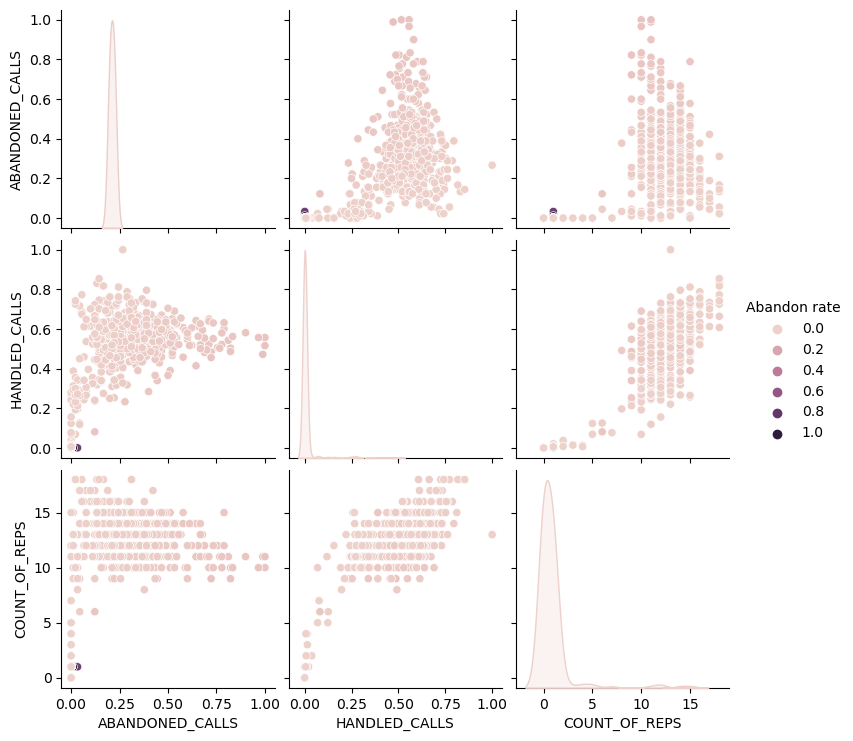

In [32]:
# We graph the relationship between the variables and the Abandon rate
sns.pairplot(df1[['ABANDONED_CALLS', 'HANDLED_CALLS', 'COUNT_OF_REPS','Abandon rate']], diag_kind = 'kde', hue = 'Abandon rate')

In [33]:
plt.show()

### Obtaining the number of days to determine the training and test dataset

In [34]:
days_dataset = (df1.index.max()-df1.index.min()) / np.timedelta64(1,'D')
df1=df1.drop('Abandon rate',axis='columns')
# We will use 75% of the dataset as training and the rest as testing
steps = int(days_dataset*0.25)
df_train = df1[:-steps]
df_test = df1[-steps:]
inputs_tr = df_train.drop('COUNT_OF_REPS', axis='columns')
target_tr = df_train[['COUNT_OF_REPS']]
inputs_te = df_test.drop('COUNT_OF_REPS', axis='columns')
target_te = df_test[['COUNT_OF_REPS']]

In [38]:
# Verifying the start and end dates of the dataset
print(f'Train dates: {df_train.index.min()} --- {df_train.index.max()} (n={len(df_train)})')
print(f'Test dates: {df_test.index.min()} --- {df_test.index.max()} (n={len(df_test)})')

Train dates: 2021-01-01 00:00:00 --- 2022-07-01 00:00:00 (n=547)
Test dates: 2022-07-02 00:00:00 --- 2022-12-29 00:00:00 (n=181)


In [39]:
# Plotting the train and test Count of reps variable
fig, ax = plt.subplots(figsize = (9,4))
df_train['COUNT_OF_REPS'].plot(ax=ax, label = 'train set')
df_test['COUNT_OF_REPS'].plot(ax=ax, label = 'test set')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend()

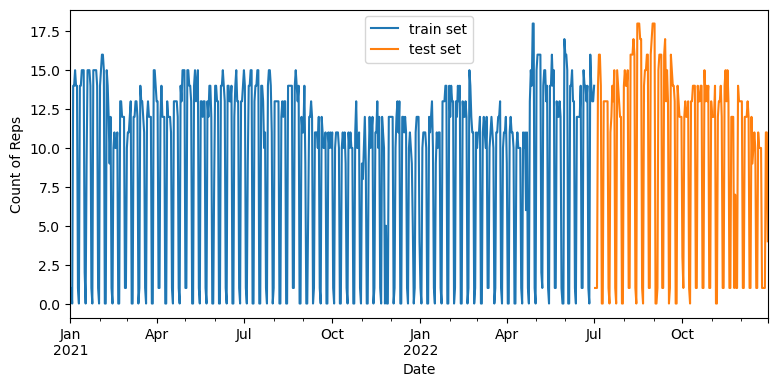

In [40]:
plt.show()

In [41]:
# Plotting the train and test Handled calls variable
fig, ax = plt.subplots(figsize = (9,4))
df_train['HANDLED_CALLS'].plot(ax=ax, label = 'train set')
df_test['HANDLED_CALLS'].plot(ax=ax, label = 'test set')
plt.xlabel('Date')
plt.ylabel('Handled calls')
ax.legend()

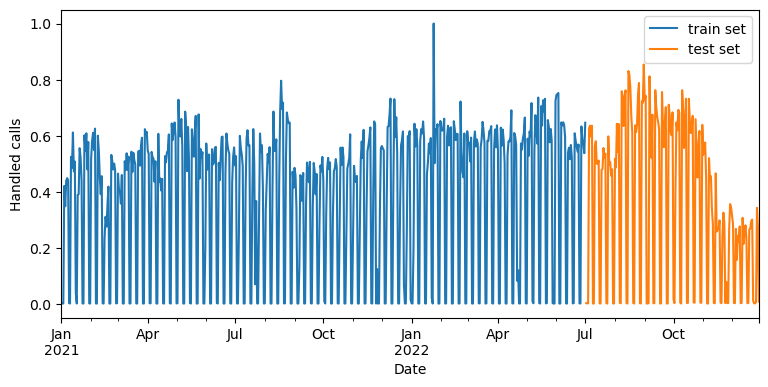

In [42]:
plt.show()

In [43]:
# Plotting the train and test Abandoned Calls variable
fig, ax = plt.subplots(figsize = (9,4))
df_train['ABANDONED_CALLS'].plot(ax=ax, label = 'train set')
df_test['ABANDONED_CALLS'].plot(ax=ax, label = 'test set')
plt.xlabel('Date')
plt.ylabel('Abandoned calls')
ax.legend()

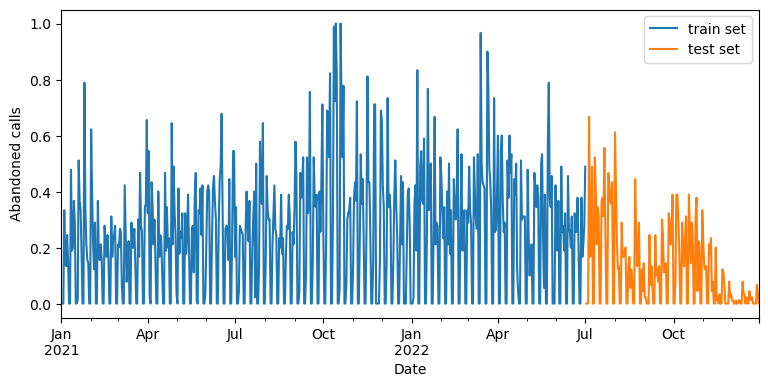

In [44]:
plt.show()

In [45]:
# Using the Dickey Fuller, we test to see if it the time-series is stationary
result = adfuller(df['ABANDONED_CALLS'])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

p-value: 0.106359
	1%: -3.440
	5%: -2.866
	10%: -2.569
Failed to Reject Ho - Time Series is Non-Stationary


Because the value is greater than 0.05, the time series is non-stationary.

# Models

## XGBoost

In [46]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(inputs_tr, target_tr,
        eval_set=[(inputs_tr, target_tr), (inputs_te, target_te)],
       verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

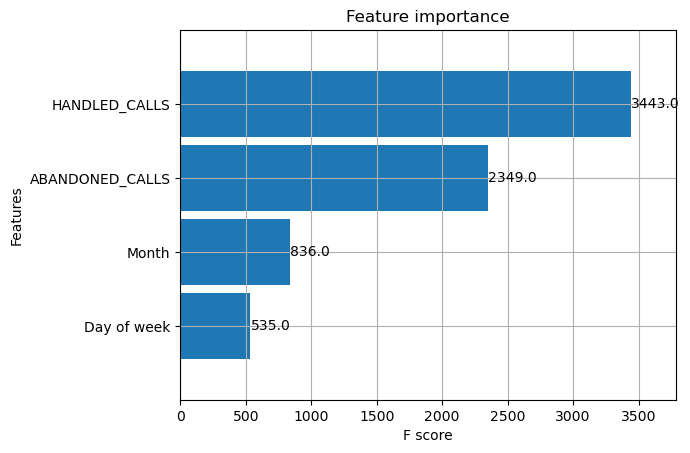

In [47]:
plot_importance(reg, height=0.9)
plt.show()

In [48]:
df_xgb = df_test.copy()
df_xgb['XGB prediction'] = reg.predict(inputs_te)
df_xgb_plot = pd.concat([df_xgb, df_train], sort=False)

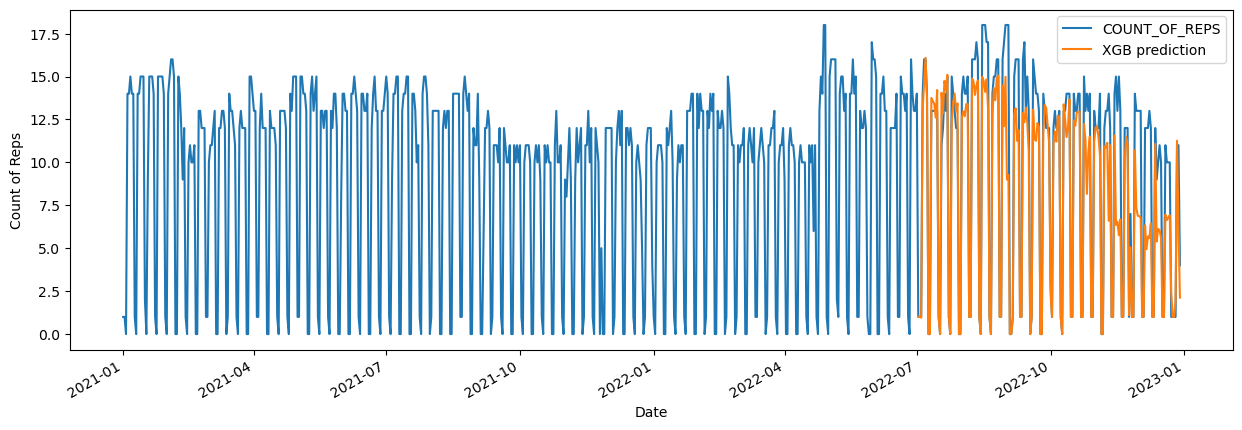

In [51]:
# We plot the prediction vs the real data
df_xgb_plot[['COUNT_OF_REPS','XGB prediction']].plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Count of Reps')
plt.show()

## Random Forest Regressor

In [52]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=1),
                lags = steps
        )
forecaster.fit(y=df_train['COUNT_OF_REPS'])
predictions = forecaster.predict(steps = steps)

In [55]:
predictions.head(5)

2022-07-02     0.69
2022-07-03     0.36
2022-07-04    11.66
2022-07-05    12.74
2022-07-06    12.74
Freq: D, Name: pred, dtype: float64

In [56]:
# We plot the prediction vs the real data
fig, ax = plt.subplots(figsize=(9, 4))
df_train['COUNT_OF_REPS'].plot(ax=ax, label='train set')
df_test['COUNT_OF_REPS'].plot(ax=ax, label='test set')
predictions.plot(ax=ax, label='RF predictions')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend();

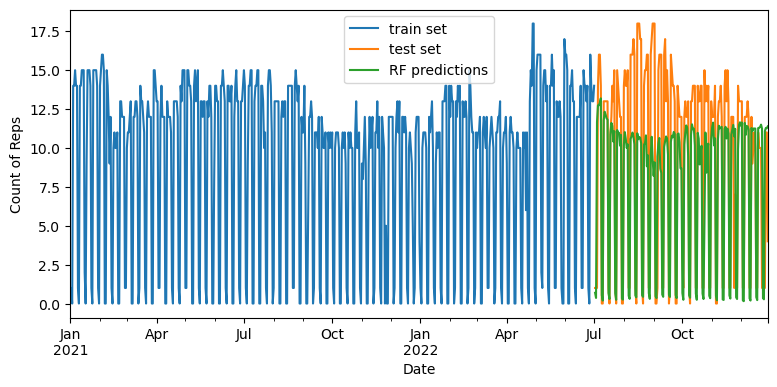

In [57]:
plt.show()

In [58]:
# Calculating the test error
error_mse = mean_squared_error(y_true = df_test['COUNT_OF_REPS'], y_pred = predictions)
print(f'Test error (mse): {error_mse}')

Test error (mse): 13.393671823204421


### Hyperparameter tuning

In [59]:
lags_grid = [10,20]
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

In [61]:
# Using the grid_search_forecaster to optimize the hyperparameters
results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = df_train['COUNT_OF_REPS'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(df_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:50<00:00, 25.39s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 4.628668428319032



In [62]:
results_grid

lags  \
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                    params  mean_squared_error  max_depth  \
10  {'max_depth': 10, 'n_estimators': 100}            4.628668         10   
11  {'max_depth': 10, 'n_estimators': 500}            4.758062         10   
1    {'max_depth': 3, 'n_estimators': 500}            4.833867          3   
0    {'max_depth': 3, 'n_estimators': 100}            4.849696          3   
2    {'max_depth': 5, 'n_estimators': 100}            4.868033          5   
3    {'max_depth': 5, 'n_estimators': 500}            4.870722          5   
6    {'max_depth': 3, 'n_estimators': 100}            4.871192          3   
8    {'max_depth': 5, 'n_estimators': 100}            4.880657          5   
7    {'max_depth': 3, 'n_estimators': 500}            4.881585          3   
9    {'max_depth': 5, 'n_estimators': 500}            5.075854          5   
5   {'max_depth': 10, 'n_estimators': 500}            5.307247         10   
4   {'max_depth': 10, 'n_estimators': 100}            5.359375         10   

    n_estimators  
10           100  
11           500  
1            500  
0            100  
2            100  
3            500  
6            100  
8            100  
7            500  
9            500  
5            500  
4            100

In [71]:
# The model is then updated with the results from the grid_search_forecaster
regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=1)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=df_train['COUNT_OF_REPS'])

In [72]:
predictions = forecaster.predict(steps=steps)
fig, ax = plt.subplots(figsize=(9, 4))
df_train['COUNT_OF_REPS'].plot(ax=ax, label='train set')
df_test['COUNT_OF_REPS'].plot(ax=ax, label='test set')
predictions.plot(ax=ax, label='RF predictions')
plt.xlabel('Date')
plt.ylabel('Count of Reps')
ax.legend();

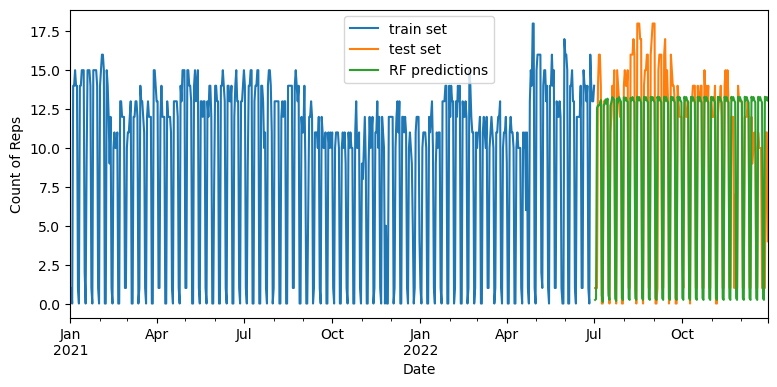

In [74]:
plt.show()

In [75]:
# Calculamos el error del modelo
error_mse = mean_squared_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 7.651676675403095


## Recurrent Neural Networks

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [77]:
model_RNN = Sequential()
model_RNN.add(LSTM(units = 50, return_sequences = True, input_shape = (inputs_tr.shape[1], 1)))
model_RNN.add(Dropout(0.2))
model_RNN.add(LSTM(units = 50, return_sequences = True))
model_RNN.add(Dropout(0.2))
model_RNN.add(LSTM(units = 50, return_sequences = True))
model_RNN.add(Dropout(0.2))
model_RNN.add(LSTM(units = 50))
model_RNN.add(Dropout(0.2))
model_RNN.add(Dense(units = 1))

2023-01-23 20:18:45.657602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 20:18:46.063894: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 20:18:46.064504: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 20:18:46.097985: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [78]:
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 4, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [79]:
model_RNN.compile(optimizer = 'adam', loss = 'mean_absolute_error')

In [80]:
model_RNN_history = model_RNN.fit(inputs_tr, target_tr, epochs = 100, batch_size = 32, verbose = 0, validation_split=0.2)

2023-01-23 20:19:02.529521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-23 20:19:07.604849: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [81]:
hist_RNN=pd.DataFrame(model_RNN_history.history)
hist_RNN['epoch']=model_RNN_history.epoch
hist_RNN.tail()

loss  val_loss  epoch
95  1.174764  1.452265     95
96  1.165629  1.426937     96
97  1.203077  1.424666     97
98  1.193226  1.429427     98
99  1.148746  1.448720     99

In [82]:
pred_reps_RNN = model_RNN.predict(inputs_te)

6/6 [==============================] - 1s 2ms/step


In [83]:
df_RNN = df_test.copy()
df_RNN['RNN prediction'] = pred_reps_RNN

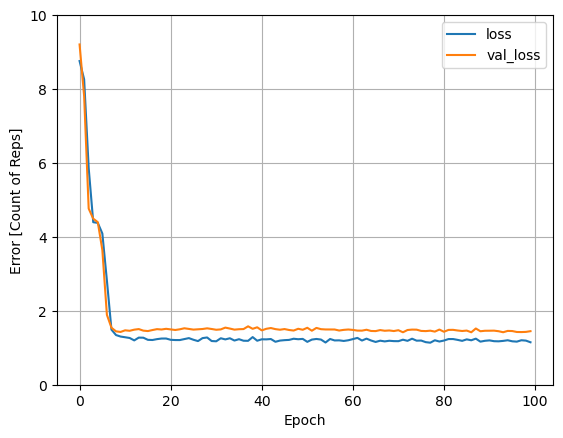

In [85]:
# Plotting loss and validation loss
plt.plot(model_RNN_history.history['loss'], label='loss')
plt.plot(model_RNN_history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [Count of Reps]')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
df_all_RNN = pd.concat([df_RNN, df_train], sort=False)

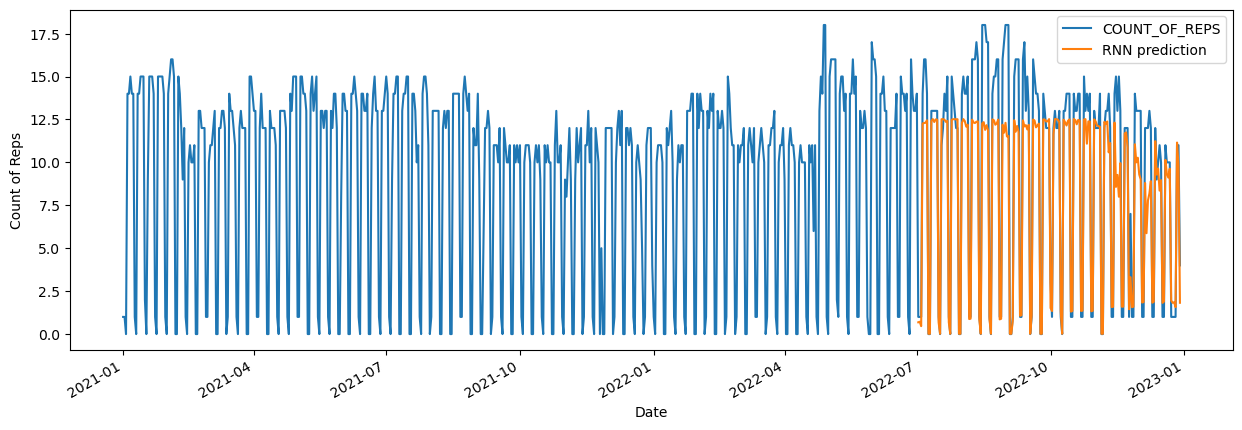

In [87]:
df_all_RNN[['COUNT_OF_REPS','RNN prediction']].plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Count of Reps')
plt.show()

# Model comparison

In [88]:
rf_df = predictions.to_frame()
rf_df=rf_df.rename(columns={"pred":'RF prediction'})

In [89]:
rf_df

RF prediction
2022-07-02       0.231915
2022-07-03       0.286703
2022-07-04      12.567932
2022-07-05      12.736240
2022-07-06      12.735113
...                   ...
2022-12-25       0.233499
2022-12-26      13.288579
2022-12-27      13.058354
2022-12-28      13.274300
2022-12-29      13.056248

[181 rows x 1 columns]

In [90]:
df_all = df_xgb_plot.copy()
df_all['RF prediction'] = rf_df['RF prediction']
df_all['RNN prediction'] = df_all_RNN['RNN prediction']
df_all[['COUNT_OF_REPS','XGB prediction','RF prediction', 'RNN prediction']].plot(figsize=(25,10))
plt.xlabel('Date')
plt.ylabel('Count of Reps')

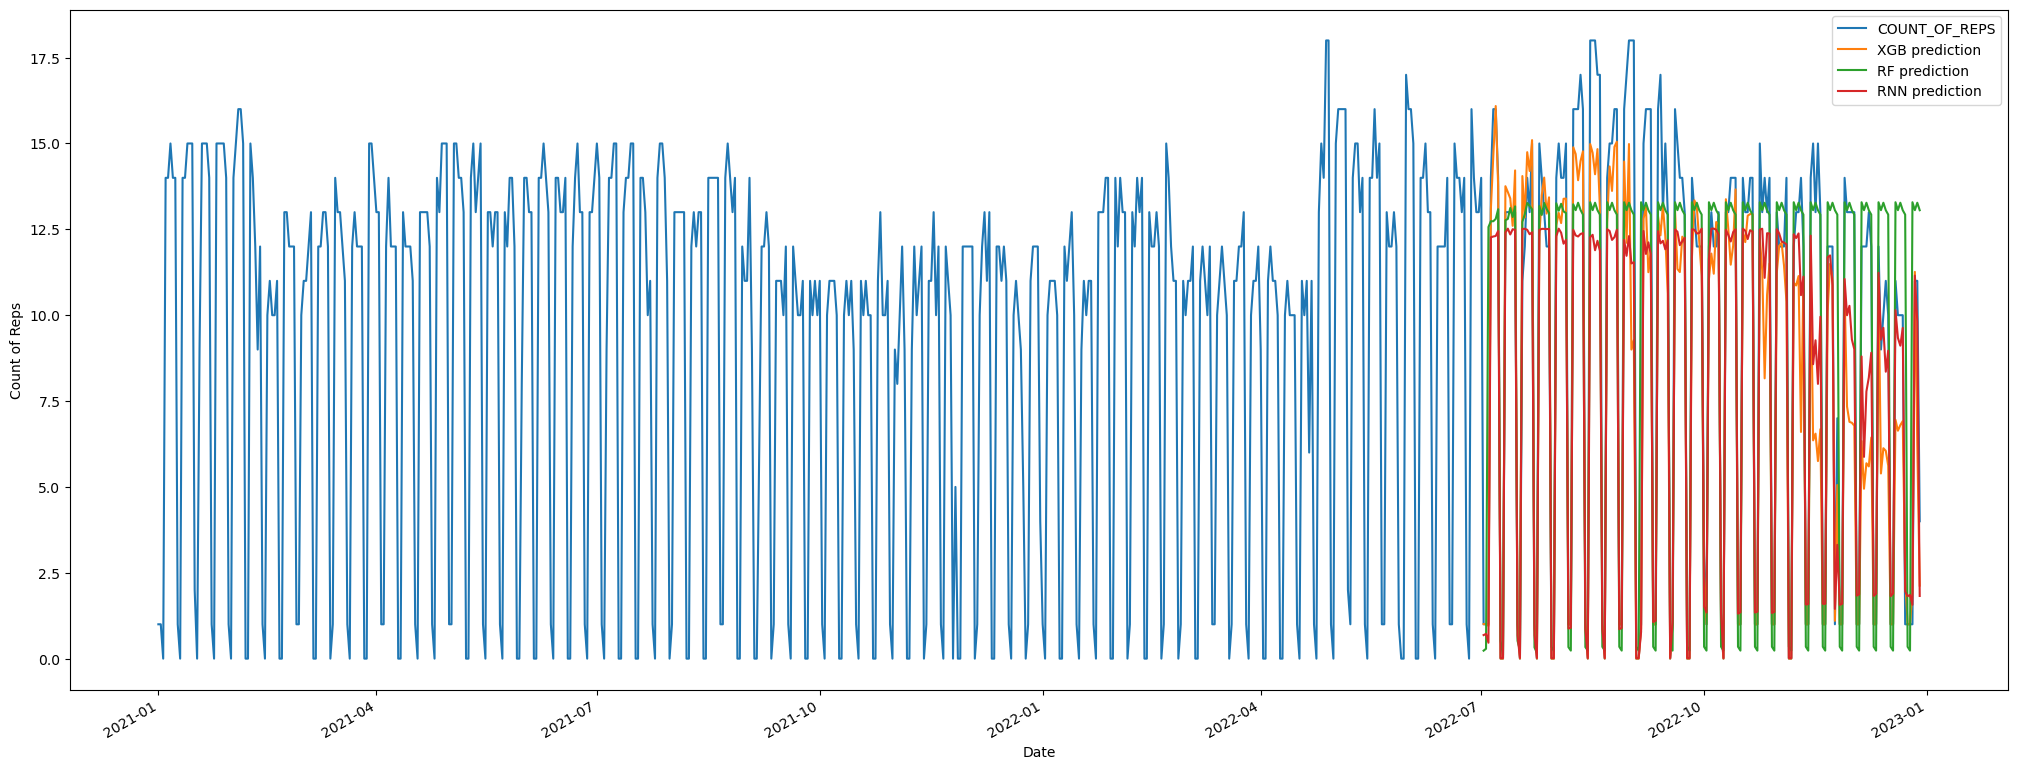

In [94]:
# Showing all 4 models
plt.show()

# Each algorithm by separate

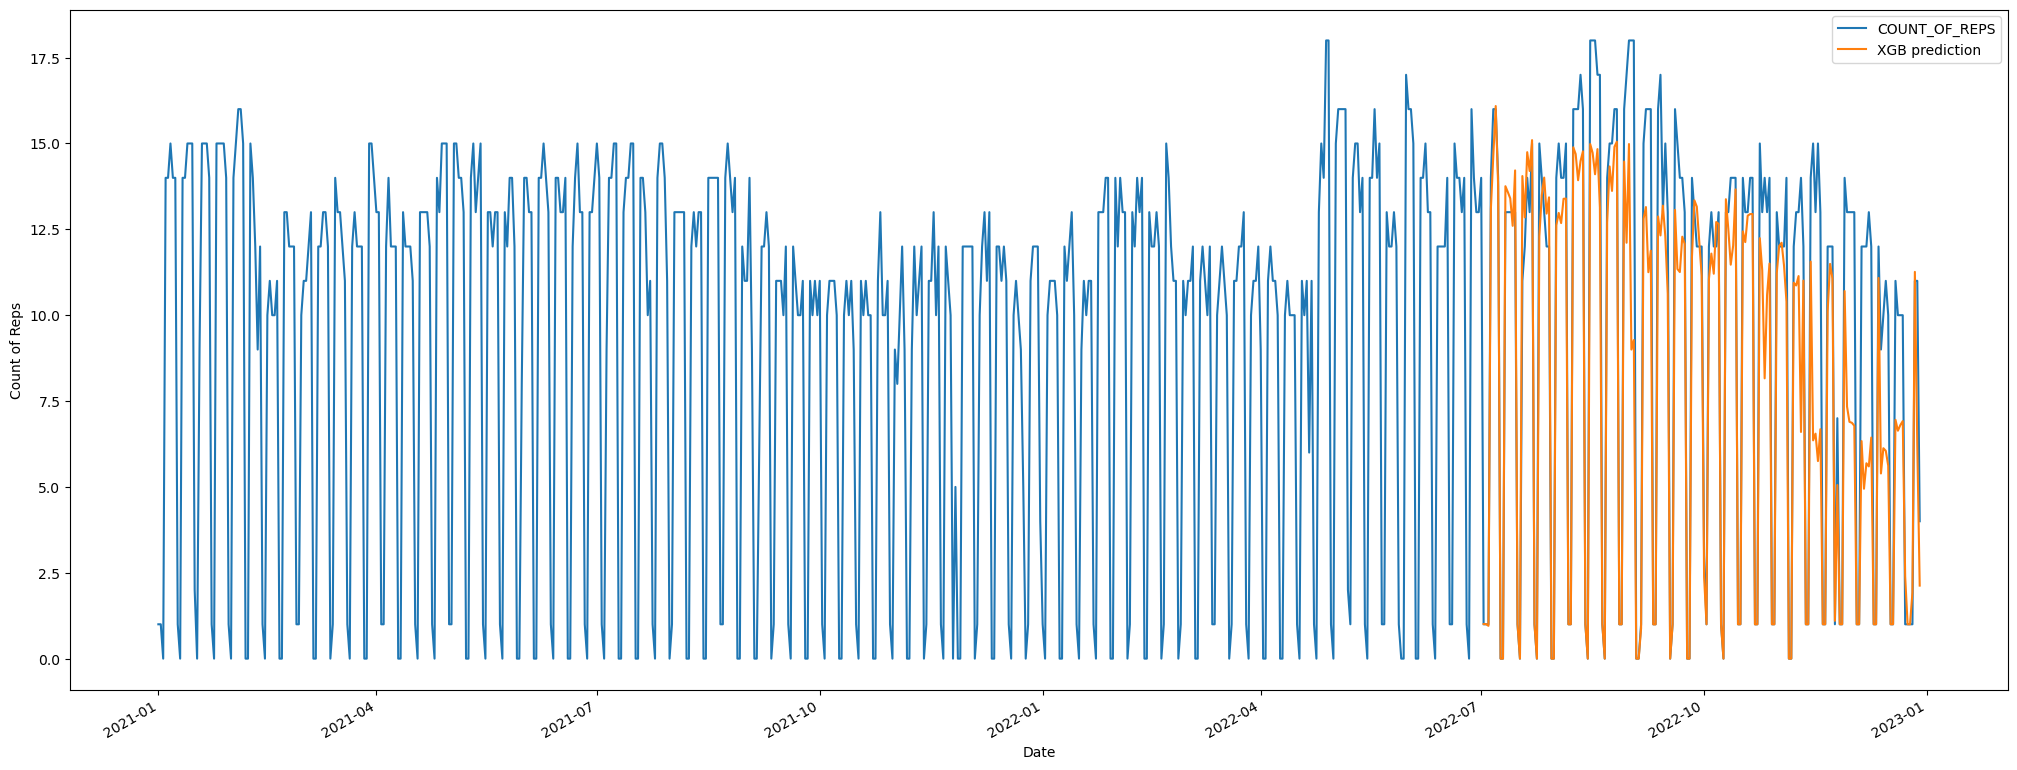

In [95]:

df_all[['COUNT_OF_REPS','XGB prediction']].plot(figsize=(25,10))
plt.xlabel('Date')
plt.ylabel('Count of Reps')
plt.show()

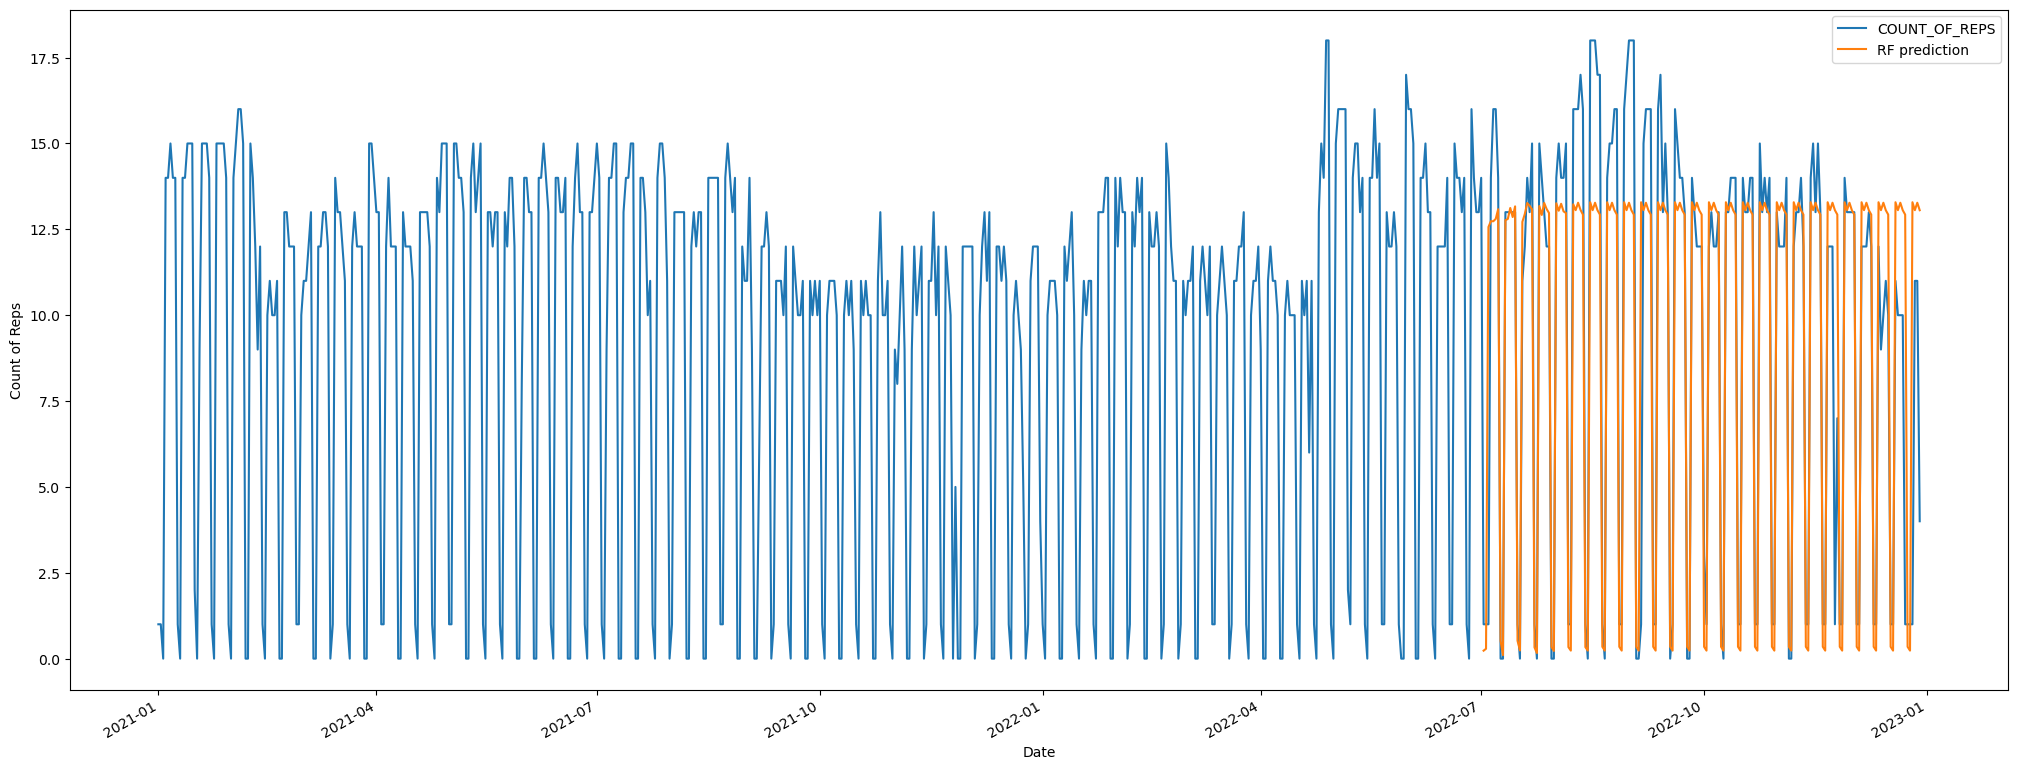

In [96]:
df_all[['COUNT_OF_REPS','RF prediction']].plot(figsize=(25,10))
plt.xlabel('Date')
plt.ylabel('Count of Reps')
plt.show()

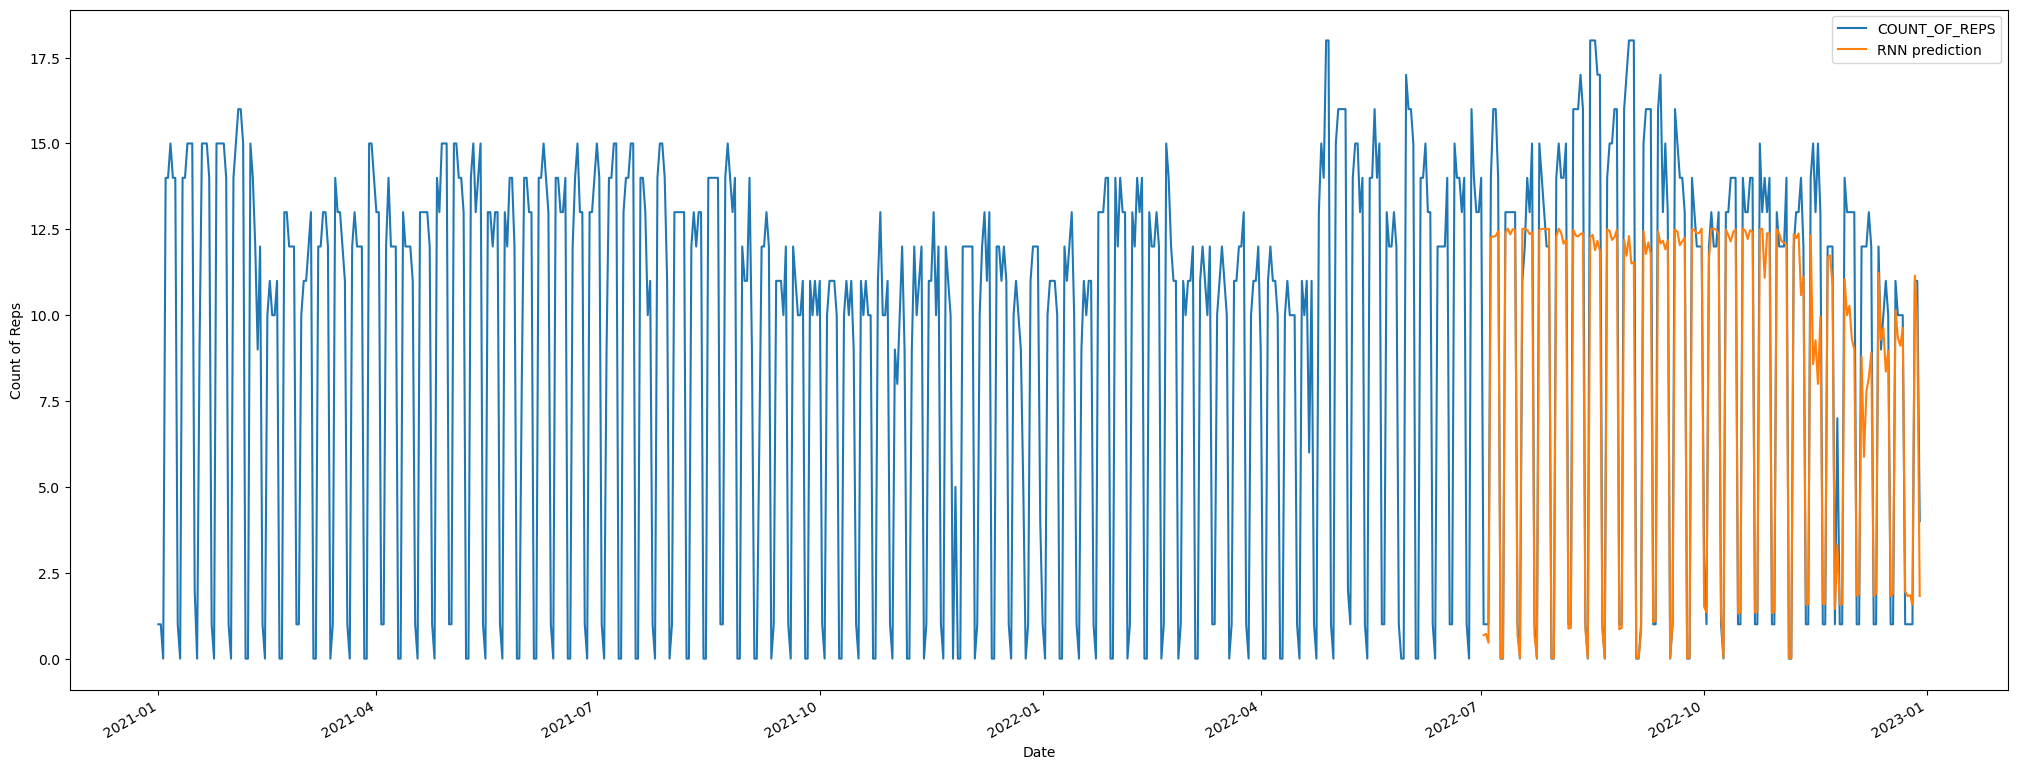

In [97]:
df_all[['COUNT_OF_REPS','RNN prediction']].plot(figsize=(25,10))
plt.xlabel('Date')
plt.ylabel('Count of Reps')
plt.show()

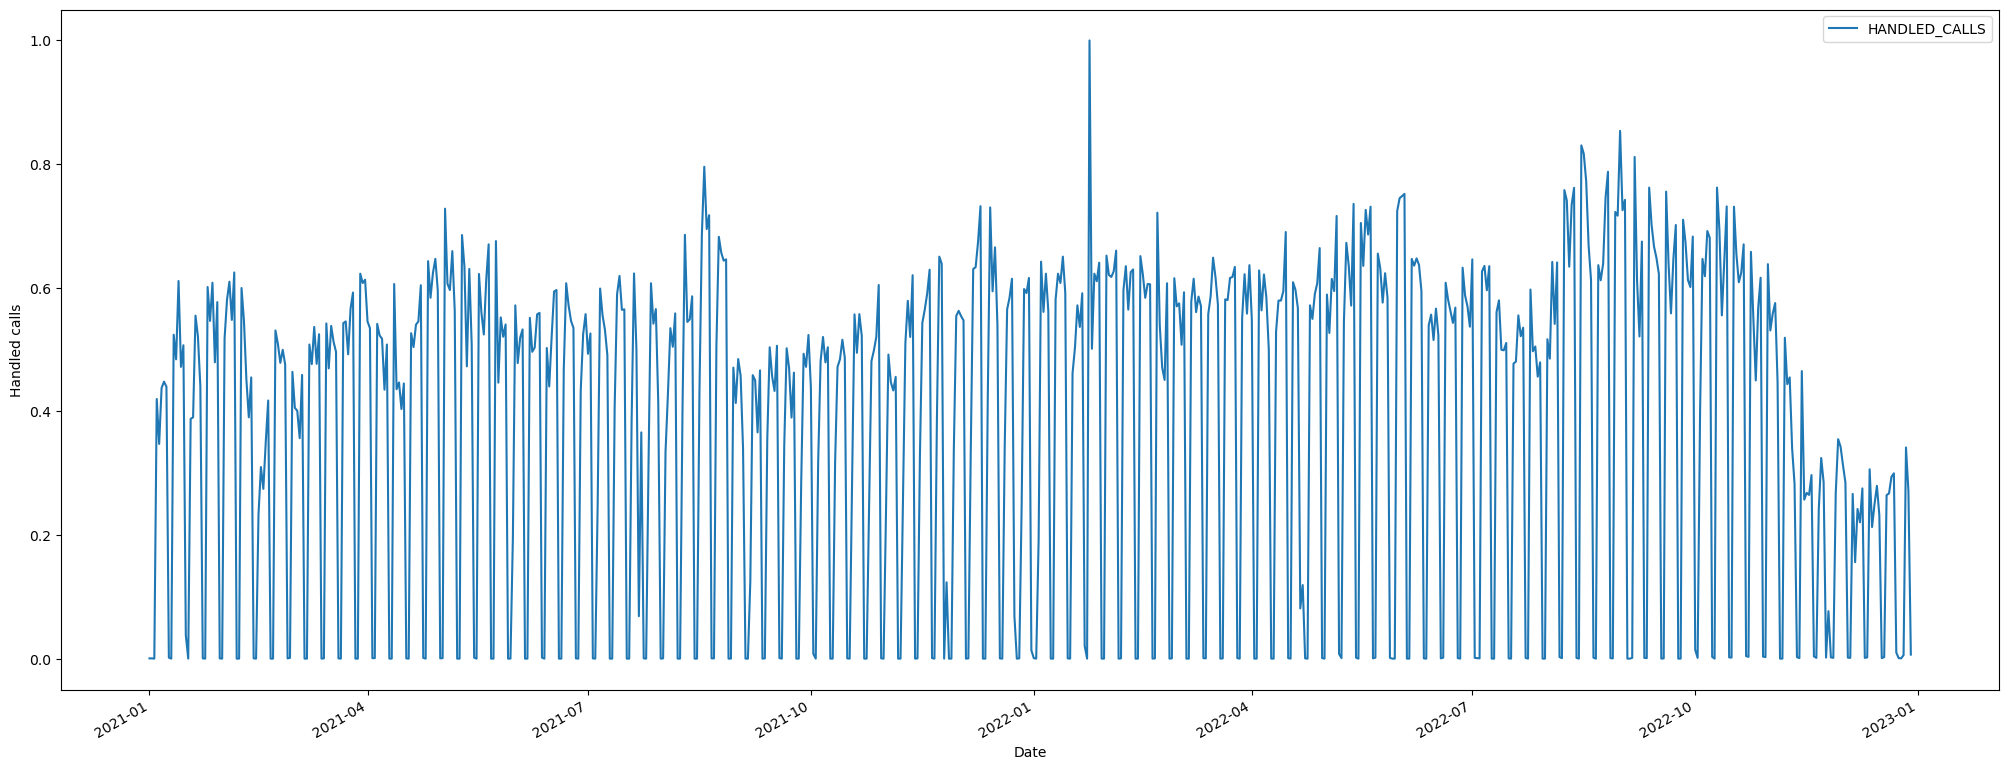

In [98]:
# Handled calls
df_all[['HANDLED_CALLS']].plot(figsize=(25,10))
plt.xlabel('Date')
plt.ylabel('Handled calls')
plt.show()

In [99]:
# Calculating the error of the model (XGB)
error_mse_XGB = mean_squared_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = df_xgb['XGB prediction']
            )
error_mae_XGB = mean_absolute_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = df_xgb['XGB prediction']
            )
print(f"Test error (mse): {error_mse_XGB}")
print(f"Test error (mae): {error_mae_XGB}")

Test error (mse): 7.588454539846061
Test error (mae): 1.73812900071781


In [100]:
# Calculating the error of the model (RF)
error_mse_RF = mean_squared_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = rf_df['RF prediction']
            )
error_mae_RF = mean_absolute_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = rf_df['RF prediction']
            )
print(f"Test error (mse): {error_mse_RF}")
print(f"Test error (mae): {error_mae_RF}")

Test error (mse): 7.651676675403095
Test error (mae): 1.6511026485730367


In [101]:
# Calculating the error of the model (RNN)
error_mse_RNN = mean_squared_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = df_RNN['RNN prediction']
            )
error_mae_RNN = mean_absolute_error(
                y_true = df_test['COUNT_OF_REPS'],
                y_pred = df_RNN['RNN prediction']
            )
print(f"Test error (mse): {error_mse_RNN}")
print(f"Test error (mae): {error_mae_RNN}")

Test error (mse): 5.576313320372265
Test error (mae): 1.6278584566564192


In [102]:
test_results={}
test_results['XGBoost']=[error_mse_XGB,error_mae_XGB]
test_results['Random Forest']=[error_mse_RF,error_mae_RF]
test_results['Recurrent Neural Network']=[error_mse_RNN,error_mae_RNN]

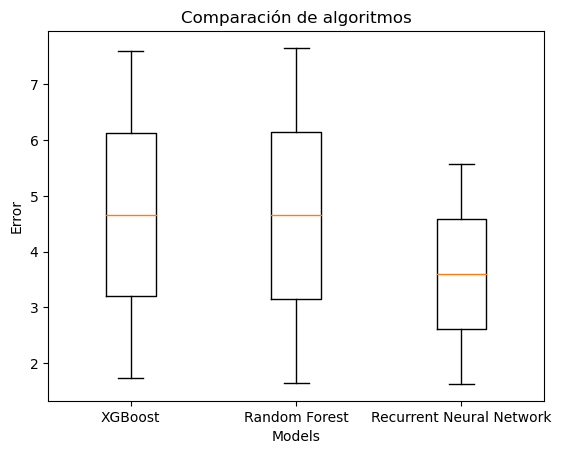

In [103]:
# Plotting the algorithm comparison
plt.boxplot(test_results.values(), labels=test_results.keys())
plt.title('Comparación de algoritmos')
plt.xlabel('Models')
plt.ylabel('Error')
plt.show()

In [104]:
print(f'XGBoost Model: \nError del test (ecm): {error_mse_XGB} \nError del test (eam): {error_mae_XGB}')
print(f'Random Forest Model: \nError del test (ecm): {error_mse_RF} \nError del test (eam): {error_mae_RF}')
print(f'RNN Model: \nError del test (ecm): {error_mse_RNN} \nError del test (eam): {error_mae_RNN}')

Modelo XGBoost: 
Error del test (ecm): 7.588454539846061 
Error del test (eam): 1.73812900071781
Modelo Random Forest: 
Error del test (ecm): 7.651676675403095 
Error del test (eam): 1.6511026485730367
Modelo RNN: 
Error del test (ecm): 5.576313320372265 
Error del test (eam): 1.6278584566564192
